In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
#!pip install pytorch_lightning
#!pip install pytorch_forecasting
#!pip install tensorflow
#!pip install tensorboard

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder 
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
import tensorboard as tb

In [4]:
# Get device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
#Load the data
data = pd.read_csv("/notebooks/demand_pv_temp_forecast_timefeatures_hols_v2_nsw_month_series_clean.csv")

In [6]:
# Create hold out dataset
holdout = data[data.DATETIME > '2021-02-01']
data = data[data.DATETIME < '2021-02-01']

In [7]:
data.drop([ 'LOCATION', 'FORECASTDEMAND', 'SUNRISE', 'SUNSET'], axis=1, inplace=True)
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
data.replace(booleanDictionary, inplace=True)
data.sample(10, random_state=48)

,STATE,DATETIME,TOTALDEMAND,POWER,TEMPERATURE,Weekday,Quarter,Month,Season,Day,Year,DAYTYPE,HOLIDAY,time_idx,month_idx
10098,NSW,2018-10-31 09:00:00,7852.54,918.191,23.5,Wednesday,4,10,Spring,31,2018,Day,FALSE,18,1458
15762,NSW,2019-02-27 09:00:00,8376.18,629.638,24.2,Wednesday,1,2,Summer,27,2019,Day,FALSE,18,1266
6811,NSW,2018-08-23 21:30:00,9548.54,0.000,12.8,Thursday,3,8,Winter,23,2018,Night,FALSE,43,1099
39101,NSW,2020-06-28 14:30:00,7536.81,762.730,15.6,Sunday,2,6,Winter,28,2020,Day,FALSE,29,1325
10427,NSW,2018-11-07 05:30:00,7389.15,22.826,21.3,Wednesday,4,11,Spring,7,2018,Day,FALSE,11,299
24512,NSW,2019-08-29 16:00:00,9338.58,267.570,12.0,Thursday,3,8,Winter,29,2019,Day,FALSE,32,1376
28999,NSW,2019-12-01 03:30:00,5844.29,0.000,17.3,Sunday,4,12,Summer,1,2019,Night,FALSE,7,7
39301,NSW,2020-07-02 18:30:00,10107.38,0.000,17.9,Thursday,3,7,Winter,2,2020,Night,FALSE,37,85
33701,NSW,2020-03-08 02:30:00,5846.61,0.000,17.9,Sunday,1,3,Autumn,8,2020,Night,FALSE,5,341
8120,NSW,2018-09-20 04:00:00,6255.33,0.000,11.8,Thursday,3,9,Spring,20,2018,Night,FALSE,8,920


In [8]:
# Creating TimeSeriesDataSet
max_prediction_length = 48
max_encoder_length = 48
training_cutoff = data["month_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="month_idx",
    target="TOTALDEMAND",
    group_ids=["Month", "Year"],
    min_encoder_length= max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["Weekday", "Season", "DAYTYPE", "HOLIDAY"],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Quarter", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "TOTALDEMAND",
        "TEMPERATURE",
        "POWER"
    ],
    target_normalizer=GroupNormalizer(
        groups=["Month", "Year"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [9]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [10]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [11]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

903.8245849609375

Train model

In [12]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("/notebooks/lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=1,
    #weights_summary="top",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 22.4k


In [13]:
# fit network


tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 51    
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [15]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
#(actuals - predictions).abs().mean()
(actuals - predictions).abs().mean().item()

220.55174255371094

In [16]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

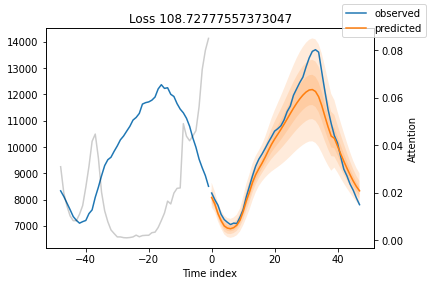

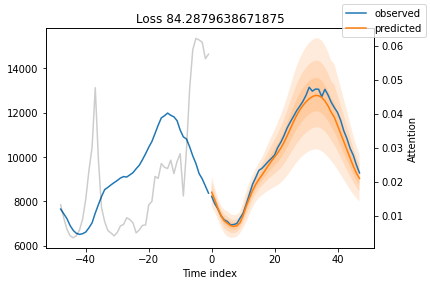

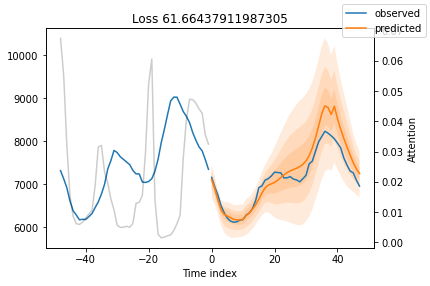

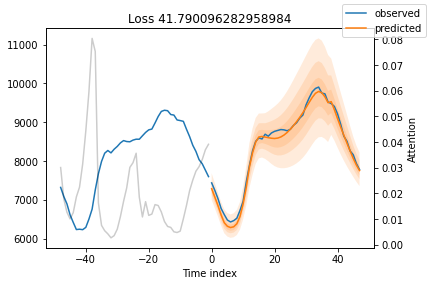

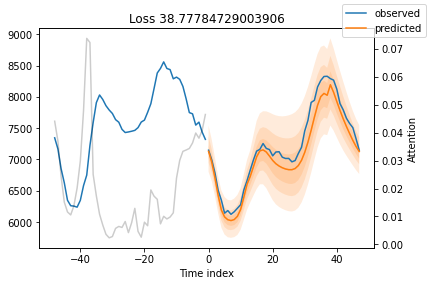

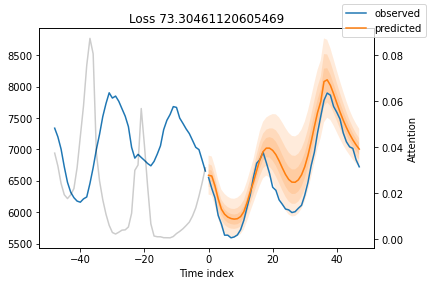

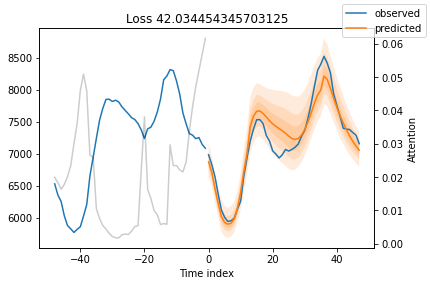

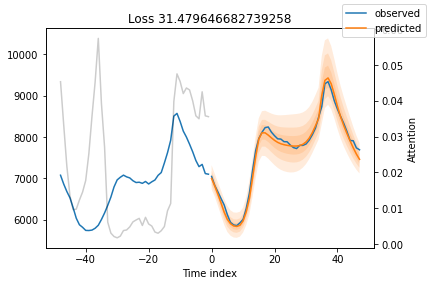

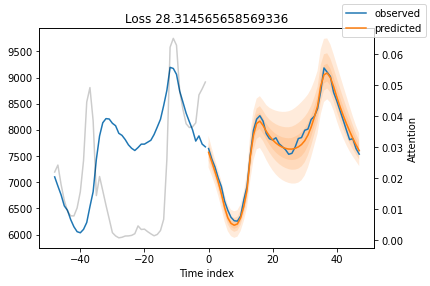

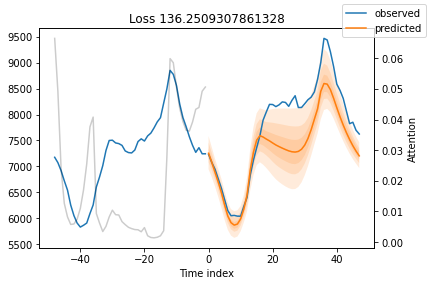

In [17]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [18]:
# raw_prediction, x  =best_tft.predict(
 #   training.filter(lambda x: (x.Season == "Summer") & (x.HOLIDAY == "TRUE")),
  #  mode="raw",
 #   return_x = True
#)
#best_tft.plot_prediction(x, raw_prediction, idx=0);

Predict on new data

In [19]:
#holdout
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
holdout.replace(booleanDictionary, inplace=True)
holdout.sample(10, random_state=48)

,STATE,DATETIME,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,FORECASTDEMAND,Weekday,Quarter,Month,Season,Day,Year,SUNRISE,SUNSET,DAYTYPE,HOLIDAY,time_idx,month_idx
51518,NSW,2021-03-14 07:00:00,6784.86,81.803,Bankstown,19.9,6681.597027,Sunday,1,3,Autumn,14,2021,2021-03-14 05:54:00,2021-03-14 18:16:00,Day,FALSE,14,638
50566,NSW,2021-02-22 11:00:00,8197.48,2187.427,Bankstown,27.6,8053.211778,Monday,1,2,Summer,22,2021,2021-02-22 05:38:00,2021-02-22 18:41:00,Day,FALSE,22,1030
51128,NSW,2021-03-06 04:00:00,5967.51,0.000,Bankstown,17.7,5878.560506,Saturday,1,3,Autumn,6,2021,2021-03-06 05:48:00,2021-03-06 18:26:00,Night,FALSE,8,248
49727,NSW,2021-02-04 23:30:00,7597.36,0.000,Bankstown,22.5,7540.722286,Thursday,1,2,Summer,4,2021,2021-02-04 05:20:00,2021-02-04 18:59:00,Night,FALSE,47,191
50929,NSW,2021-03-02 00:30:00,7380.75,0.000,Bankstown,21.7,7274.652500,Tuesday,1,3,Autumn,2,2021,2021-03-02 05:45:00,2021-03-02 18:31:00,Night,FALSE,1,49
49633,NSW,2021-02-03 00:30:00,6868.35,0.000,Bankstown,18.2,6919.530139,Wednesday,1,2,Summer,3,2021,2021-02-03 05:19:00,2021-02-03 19:00:00,Night,FALSE,1,97
50589,NSW,2021-02-22 22:30:00,7701.62,0.000,Bankstown,20.0,7723.047941,Monday,1,2,Summer,22,2021,2021-02-22 05:38:00,2021-02-22 18:41:00,Night,FALSE,45,1053
50095,NSW,2021-02-12 15:30:00,9632.01,1038.945,Bankstown,32.8,9729.106296,Friday,1,2,Summer,12,2021,2021-02-12 05:28:00,2021-02-12 18:52:00,Day,FALSE,31,559
49590,NSW,2021-02-02 03:00:00,6228.12,0.000,Bankstown,18.0,6301.088701,Tuesday,1,2,Summer,2,2021,2021-02-02 05:18:00,2021-02-02 19:01:00,Night,FALSE,6,54
51435,NSW,2021-03-12 13:30:00,8011.66,1324.746,Bankstown,27.0,8213.687800,Friday,1,3,Autumn,12,2021,2021-03-12 05:53:00,2021-03-12 18:19:00,Day,FALSE,27,555


In [20]:
encoder_data = holdout[holdout.DATETIME < '2021-03-01']
decoder_data = holdout[holdout.DATETIME > '2021-03-01']
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

IndexError: index 2 is out of bounds for dimension 0 with size 2

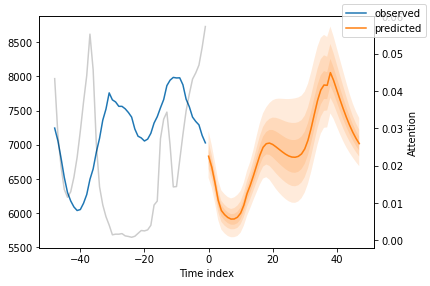

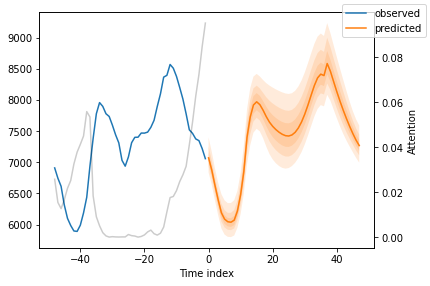

In [21]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
# calcualte mean absolute error on validation set
#actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
#new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw")

#(actuals - predictions).abs().mean().item()